Saving visualizations to: /home/yif22003/generic_food/code_results/0407_evaluate_one_sample_with_gradcam/dish_1558028194
Using device: cpu
Loading CLIPSeg model...
CLIPSeg model loaded successfully
CLIPSeg model loading time: 6.6366 seconds
Visual processor model loading time: 8.5203 seconds
Probability map generation time: 4.2564 seconds
Image preprocessing time: 0.1059 seconds
Model inference time: 0.4439 seconds

NOTE: Using original RGB and depth images for prediction.
Probability map is generated only for visualization and explainability.

Nutritional Predictions:
------------------------------
Calories    : 231.09
Mass (g)    : 164.43
Fat (g)     : 11.85
Carb (g)    : 23.87
Protein (g) : 10.07

Comparison with Ground Truth:
--------------------------------------------------
Nutrient     Predicted  Ground Truth Error      % Error   
--------------------------------------------------
Calories     231.09 228.05 3.04 1.33%
Mass (g)     164.43 172.00 7.57 4.40%
Fat (g)      11.85 11.9

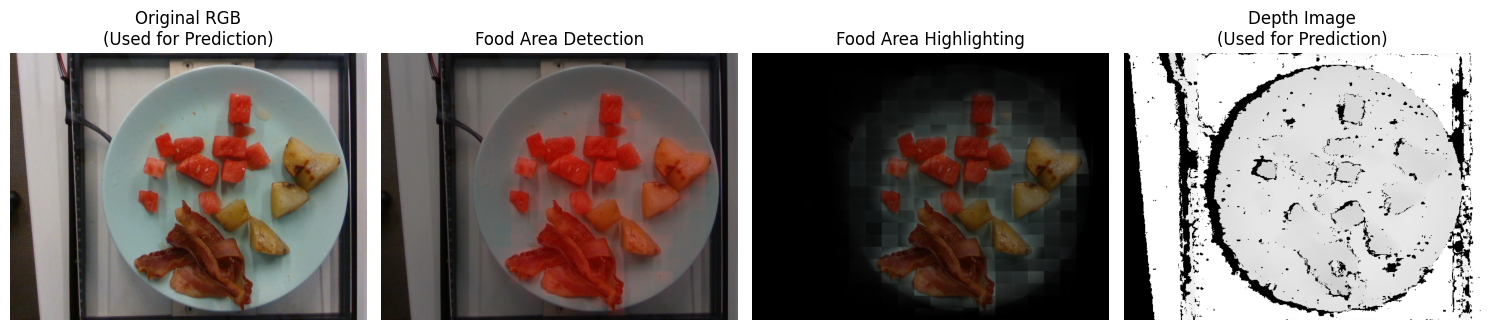


Generating GradCAM visualization for all nutrient types...
Processing Calories...
Processing Mass (g)...
Processing Fat (g)...
Processing Carb (g)...
Processing Protein (g)...


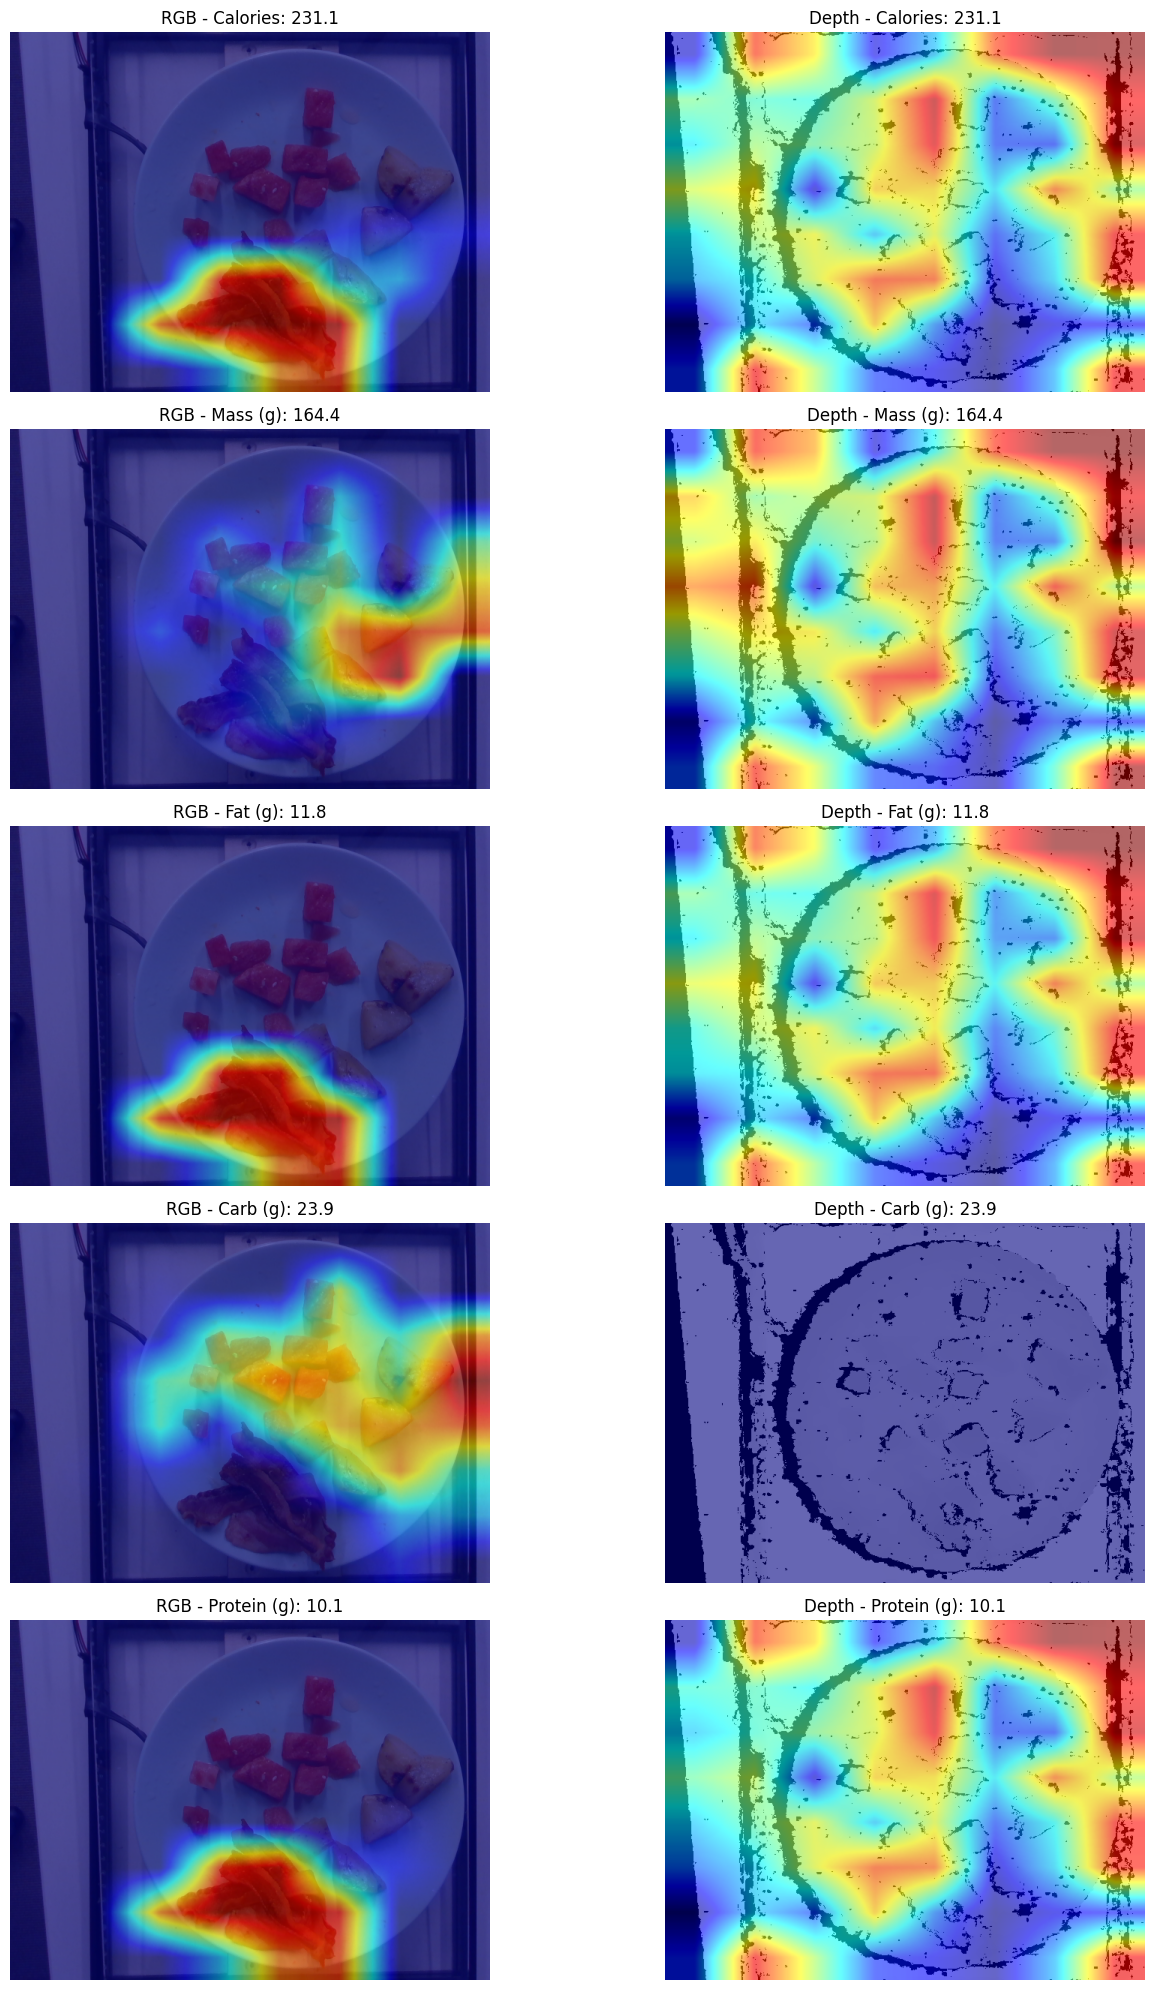

All nutrient GradCAM generation time: 108.8521 seconds


In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time
from torchvision import transforms
import warnings
warnings.filterwarnings("ignore")

# Define constants for the model
DEPTH_CLIPPING_FLAG = 1
IMAGE_SIZE_BEFORE_CROP = 260
IMAGE_SIZE = 256

# Path to the best model
MODEL_PATH = '/home/yif22003/generic_food/code_results/Ablation_studies/040625_Full_Model/best_model.pth'

def get_ground_truth(metadata_file, dish_id):
    """Extract ground truth nutrition values for a specific dish ID"""
    try:
        with open(metadata_file, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if parts[0] == dish_id:
                    return {
                        'calories': float(parts[1]),
                        'mass': float(parts[2]),
                        'fat': float(parts[3]),
                        'carb': float(parts[4]),
                        'protein': float(parts[5])
                    }
        print(f"Warning: Dish ID {dish_id} not found in metadata file")
        return None
    except Exception as e:
        print(f"Error reading metadata file: {e}")
        return None
    
# Function to load the CLIPSeg model
def load_clipseg_model():
    # First, ensure the path is in sys.path to find the module
    if '/home/yif22003/generic_food' not in sys.path:
        sys.path.append('/home/yif22003/generic_food')
    
    try:
        from clipseg import CLIPDensePredT
        print("Loading CLIPSeg model...")
        model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
        model.eval()
        
        # Load the weights
        weights_path = '/home/yif22003/generic_food/clipseg_weights/weights/rd64-uni.pth'
        model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')), strict=False)
        print("CLIPSeg model loaded successfully")
        return model
    except Exception as e:
        print(f"Error loading CLIPSeg model: {e}")
        raise

# Function to generate a probability map with CLIPSeg
def generate_prob_map(clipseg_model, rgb_img, prompt="food"):
    # Define image transformation for CLIPSeg
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((352, 352)),
    ])
    
    # Process RGB image for CLIPSeg
    clipseg_input = transform(rgb_img).unsqueeze(0)
    
    # Generate prediction
    with torch.no_grad():
        pred = clipseg_model(clipseg_input, [prompt])[0]
        # Get sigmoid of prediction for probability map
        prob_map = torch.sigmoid(pred[0][0]).numpy()
        
        # Resize probability map to original image size
        rgb_np = np.array(rgb_img)
        prob_map = cv2.resize(prob_map, (rgb_np.shape[1], rgb_np.shape[0]))
    
    return prob_map

# Define the VisualProcessor model class (same as from the training code)
class VisualProcessor(nn.Module):
    def __init__(self, num_classes=5):
        super(VisualProcessor, self).__init__()

        # Load Swin V2 Tiny models for RGB and Depth
        from torchvision.models import swin_v2_t, Swin_V2_T_Weights
        weights = Swin_V2_T_Weights.IMAGENET1K_V1

        # Create RGB model
        self.rgb_model = swin_v2_t(weights=weights)
        # Create Depth model
        self.depth_model = swin_v2_t(weights=weights)

        # Remove the classification heads
        feature_dim = self.rgb_model.head.in_features  # This is 768 for Swin V2 Tiny
        self.rgb_model.head = nn.Identity()
        self.depth_model.head = nn.Identity()

        # Define feature dimensions for each stage
        # Swin V2 Tiny has 4 stages with dimensions: [96, 192, 384, 768]
        self.stage_dims = [96, 192, 384, 768]

        # Create feature extraction dictionaries for each stage
        self.rgb_features = {}
        self.depth_features = {}

        # Feature mixer modules for each stage (RGB + Depth only)
        self.stage_mixers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim*2, dim),  # RGB + Depth
                nn.LayerNorm(dim),
                nn.GELU()
            ) for dim in self.stage_dims
        ])

        # Feature projectors to common dimension
        self.stage_projectors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim, 128),
                nn.GELU()
            ) for dim in self.stage_dims
        ])

        # Final prediction head
        self.prediction_head = nn.Sequential(
            nn.Linear(128*4, 256),  # 4 stages with 128-dim projections
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

        # Register hooks to get intermediate features
        self._register_hooks()

    def _register_hooks(self):
        """Register hooks to extract features from each stage"""

        def get_hook(stage_name, feature_dict):
            def hook(module, input, output):
                # For Swin, we perform global average pooling on the output
                # Output shape is [B, H, W, C] -> Pooled shape is [B, C]
                # First permute to [B, C, H, W] for pooling
                pooled = output.permute(0, 3, 1, 2)
                pooled = F.adaptive_avg_pool2d(pooled, 1).flatten(1)
                feature_dict[stage_name] = pooled

                # Also store the original spatial output for GradCAM
                feature_dict[stage_name + "_spatial"] = output
            return hook

        # Register hooks for RGB backbone
        self.rgb_model.features[1].register_forward_hook(get_hook("stage0", self.rgb_features))  # First stage
        self.rgb_model.features[3].register_forward_hook(get_hook("stage1", self.rgb_features))  # Second stage
        self.rgb_model.features[5].register_forward_hook(get_hook("stage2", self.rgb_features))  # Third stage
        self.rgb_model.features[7].register_forward_hook(get_hook("stage3", self.rgb_features))  # Fourth stage

        # Register hooks for Depth backbone
        self.depth_model.features[1].register_forward_hook(get_hook("stage0", self.depth_features))  # First stage
        self.depth_model.features[3].register_forward_hook(get_hook("stage1", self.depth_features))  # Second stage
        self.depth_model.features[5].register_forward_hook(get_hook("stage2", self.depth_features))  # Third stage
        self.depth_model.features[7].register_forward_hook(get_hook("stage3", self.depth_features))  # Fourth stage

    def forward(self, rgb, depth):
        """
        Forward pass through the visual processing
        
        Args:
            rgb: RGB images, tensor of shape [B, 3, H, W]
            depth: Depth images, tensor of shape [B, 3, H, W]
            
        Returns:
            predictions: Nutritional predictions, tensor of shape [B, 5]
            final_visual_features: Final stage visual features for alignment, tensor of shape [B, 768]
        """
        # Forward pass through RGB model
        _ = self.rgb_model(rgb)

        # Forward pass through Depth model
        _ = self.depth_model(depth)

        # Collect and mix features from each stage
        mixed_features = []

        for i in range(4):  # 4 stages
            stage_name = f"stage{i}"

            # Get RGB and Depth features
            rgb_feat = self.rgb_features[stage_name]
            depth_feat = self.depth_features[stage_name]

            # Concatenate RGB and Depth features
            concat_feat = torch.cat([rgb_feat, depth_feat], dim=1)

            # Mix features
            mixed_feat = self.stage_mixers[i](concat_feat)

            # Project to common dimension
            projected_feat = self.stage_projectors[i](mixed_feat)

            mixed_features.append(projected_feat)

        # Concatenate all mixed features for final prediction
        all_features = torch.cat(mixed_features, dim=1)

        # Final prediction
        predictions = self.prediction_head(all_features)

        # Return predictions and final visual features (for alignment, if needed)
        final_visual_features = self.rgb_features["stage3"]  # Use final stage RGB features
        
        return predictions, final_visual_features
    
class SwinTransformerGradCAM:
    """
    GradCAM implementation for Swin Transformer V2 models used in nutrition prediction
    """
    def __init__(self, model, use_rgb=True):
        """
        Initialize GradCAM
        
        Args:
            model: VisualProcessor
            use_rgb: Whether to use RGB or depth model for visualization
        """
        self.model = model
        self.use_rgb = use_rgb
        
        # Dictionary to store gradients
        self.gradients = {}
        
        # Register hooks to capture gradients
        self._register_hooks()
        
        # Set model to evaluation mode
        self.model.eval()
    
    def _register_hooks(self):
        """Register backward hooks to capture gradients"""
        
        def save_gradients(name):
            def hook(module, grad_input, grad_output):
                # Store the gradients for later use
                self.gradients[name] = grad_output[0]
            return hook
        
        # Register backward hooks on stage3 (final stage)
        if self.use_rgb:
            # For RGB path
            self.model.rgb_model.features[7].register_backward_hook(save_gradients("rgb_stage3"))
        else:
            # For depth path
            self.model.depth_model.features[7].register_backward_hook(save_gradients("depth_stage3"))
    
    def _compute_gradcam(self, feature_map, gradients, target_size=None):
        """
        Compute GradCAM activation map
        
        Args:
            feature_map: Feature map from the target layer
            gradients: Gradients flowing back to the target layer
            target_size: Size to resize the output heatmap (optional)
            
        Returns:
            cam: GradCAM heatmap
        """
        # Convert features to the right format
        # For Swin Transformer, the feature maps are [B, H, W, C]
        # Convert to [B, C, H, W] for easier operations
        feature_map = feature_map.permute(0, 3, 1, 2)  # [B, H, W, C] -> [B, C, H, W]
        gradients = gradients.permute(0, 3, 1, 2)      # [B, H, W, C] -> [B, C, H, W]
        
        # Compute weights: global average pooling of gradients
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # [B, C, 1, 1]
        
        # Weighted sum of feature maps
        cam = torch.sum(weights * feature_map, dim=1, keepdim=True)  # [B, 1, H, W]
        
        # Apply ReLU to focus on features positively influencing the target
        cam = F.relu(cam)
        
        # Normalize each CAM separately
        for i in range(cam.size(0)):
            cam[i] = cam[i] - cam[i].min()
            if cam[i].max() > 0:
                cam[i] = cam[i] / cam[i].max()
        
        # Resize to target size if specified
        if target_size is not None:
            cam = F.interpolate(cam, size=target_size, mode='bilinear', align_corners=False)
        
        return cam
    
    def generate_nutrient_cam(self, rgb_img, depth_img, nutrient_idx=0, target_size=(256, 256)):
        """
        Generate GradCAM for a specific nutrient prediction
        
        Args:
            rgb_img: RGB image tensor [1, 3, H, W]
            depth_img: Depth image tensor [1, 3, H, W]
            nutrient_idx: Index of the nutrient to generate cam for 
                          (0=Calories, 1=Mass, 2=Fat, 3=Carb, 4=Protein)
            target_size: Size to resize the output heatmap
            
        Returns:
            cam: GradCAM heatmap [H, W]
        """
        # Ensure we're working with batched inputs
        if rgb_img.dim() == 3:
            rgb_img = rgb_img.unsqueeze(0)
        if depth_img.dim() == 3:
            depth_img = depth_img.unsqueeze(0)
        
        # Forward pass
        self.model.zero_grad()
        
        # Clear gradient dictionary
        self.gradients = {}
        
        # Get predictions
        predictions, _ = self.model(rgb_img, depth_img)
        
        # Target for backprop is the specific nutrient score
        target = predictions[0, nutrient_idx]
        
        # Backward pass (compute gradients)
        target.backward(retain_graph=True)
        
        # Get feature maps from hooks - focusing only on stage3
        if self.use_rgb:
            feature_maps = self.model.rgb_features["stage3_spatial"]
            gradients = self.gradients.get("rgb_stage3")
        else:
            feature_maps = self.model.depth_features["stage3_spatial"]
            gradients = self.gradients.get("depth_stage3")
        
        if gradients is None:
            raise ValueError("No gradients found. Make sure backward pass was executed.")
        
        # Compute GradCAM
        cam = self._compute_gradcam(feature_maps, gradients, target_size)
        
        # Convert to numpy array
        cam = cam.cpu().detach().numpy()[0, 0]  # [H, W]
        
        return cam

def apply_heatmap(img, heatmap, alpha=0.5):
    """
    Apply heatmap overlay to an image
    
    Args:
        img: numpy array RGB image [H, W, 3]
        heatmap: numpy array heatmap [H, W]
        alpha: transparency factor
        
    Returns:
        result: Image with heatmap overlay
    """
    # Convert heatmap to RGB colormap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Ensure image is in RGB format and uint8 type
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()  # Convert [C, H, W] -> [H, W, C]
        img = (img * 255).astype(np.uint8)
    elif isinstance(img, Image.Image):
        img = np.array(img)
    
    # Resize heatmap to match image dimensions if needed
    if img.shape[:2] != heatmap_colored.shape[:2]:
        heatmap_colored = cv2.resize(heatmap_colored, (img.shape[1], img.shape[0]))
    
    # Blend image with heatmap
    blended = cv2.addWeighted(img, 1-alpha, heatmap_colored, alpha, 0)
    
    return blended

def predict_nutrition(rgb_path, depth_path, visualize_nutrient_idx=None, visualize_all_nutrients=False, alpha=0.6, output_dir=None):
    """
    Predict nutrition from RGB and depth images, with optional attention visualization
    
    The workflow is:
    1. Original RGB and depth images are loaded and used directly for prediction
    2. For explainability, ClipSeg is used to generate a probability map to show 
       what areas were identified as food
    3. The probability maps are used only for visualization and explanation
    4. GradCAM is used to visualize which areas influenced the prediction
    
    Args:
        rgb_path: Path to RGB image
        depth_path: Path to depth image
        visualize_nutrient_idx: Index of nutrient to visualize attention for (optional)
                             0=Calories, 1=Mass, 2=Fat, 3=Carb, 4=Protein
        visualize_all_nutrients: If True, visualize all 5 nutrient types at once
                               (overrides visualize_nutrient_idx if both are provided)
        alpha: Transparency factor for heatmap visualization
        output_dir: Directory to save visualization figures (optional)
    """
    # Create output directory if provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        print(f"Saving visualizations to: {output_dir}")

    # Extract dish ID from path
    dish_id = os.path.basename(os.path.dirname(rgb_path))    
    # Start timing
    start_time = time.time()
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load CLIPSeg model
    clipseg_model = load_clipseg_model()
    clipseg_time = time.time()
    print(f"CLIPSeg model loading time: {clipseg_time - start_time:.4f} seconds")
    
    # Load visual processor model
    model = VisualProcessor().to(device)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
    model_time = time.time()
    print(f"Visual processor model loading time: {model_time - clipseg_time:.4f} seconds")
    
    # Load original RGB image
    original_rgb = Image.open(rgb_path).convert('RGB')
    rgb_np = np.array(original_rgb)
    
    # Load depth image (uint16 format)
    depth_img = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)  # uint16 format
    
    if DEPTH_CLIPPING_FLAG == 1:
        # Trim values ≥ 4000 to 4000
        depth_img = np.clip(depth_img, 0, 4000)
        # Normalize depth to 0-255 for easier processing
        depth_img = (depth_img / 4000.0 * 255).astype(np.uint8)
    else:
        max_depth = np.max(depth_img)
        if max_depth == 0:  # Avoid division by zero
            max_depth = 1
        depth_img = (depth_img / max_depth * 255).astype(np.uint8)
    
    # Convert single-channel depth to 3-channel by repeating
    depth_img_3channel = np.stack([depth_img, depth_img, depth_img], axis=2)

    # Save original depth image for later use
    original_depth = Image.fromarray(depth_img_3channel.copy())

    # Generate probability map using CLIPSeg (for visualization only)
    prob_map = generate_prob_map(clipseg_model, original_rgb, prompt="food")
    prob_map_time = time.time()
    print(f"Probability map generation time: {prob_map_time - model_time:.4f} seconds")
    
    # =================== VISUALIZATION ONLY ===================
    # Create direct probability map visualization for explainability
    
    # 1. Food area visualization - overlay probability map on original image
    # Create a heatmap overlay to highlight detected food areas
    prob_overlay = np.zeros_like(rgb_np)
    prob_overlay[:,:,0] = np.uint8(prob_map * 255)  # Red channel
    food_area_viz = cv2.addWeighted(rgb_np, 1-0.4, prob_overlay, 0.4, 0)
    
    # 2. For comparison, also apply probability map directly to RGB
    # This shows how the probability map would mask the image if we were using it
    direct_prob_viz = rgb_np.copy().astype(np.float32)
    for c in range(3):
        direct_prob_viz[:,:,c] = direct_prob_viz[:,:,c] * prob_map
    direct_prob_viz = direct_prob_viz.astype(np.uint8)
    # =================== END VISUALIZATION ONLY ===================
    
    # FOR MODEL INPUT: Use original RGB, not masked version
    # Convert to PIL Image for transformation
    rgb_img = Image.fromarray(rgb_np)  # Use original RGB for model input
    depth_img = Image.fromarray(depth_img_3channel)
    
    # Define transformations for model input
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE_BEFORE_CROP, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Apply transformations
    rgb_tensor = transform(rgb_img).unsqueeze(0).to(device)
    depth_tensor = transform(depth_img).unsqueeze(0).to(device)
    
    preprocessing_time = time.time()
    print(f"Image preprocessing time: {preprocessing_time - prob_map_time:.4f} seconds")
    
    # Make prediction
    with torch.no_grad():
        predictions, _ = model(rgb_tensor, depth_tensor)
    
    # Convert predictions to numpy for better printing
    predictions = predictions.cpu().numpy()[0]
    
    inference_time = time.time()
    print(f"Model inference time: {inference_time - preprocessing_time:.4f} seconds")
    
    # Print preprocessing approach
    print("\nNOTE: Using original RGB and depth images for prediction.")
    print("Probability map is generated only for visualization and explainability.")
    
    # Print nutritional predictions
    nutrient_names = ['Calories', 'Mass (g)', 'Fat (g)', 'Carb (g)', 'Protein (g)']
    print("\nNutritional Predictions:")
    print("-" * 30)
    for name, value in zip(nutrient_names, predictions):
        print(f"{name:<12}: {value:.2f}")

    # Get ground truth values
    metadata_file = '/home/yif22003/generic_food/nutrition5k_metadata/N5K_rgbd_dish_updated.txt'
    ground_truth = get_ground_truth(metadata_file, dish_id)
    if ground_truth:
        # Print comparison
        print("\nComparison with Ground Truth:")
        print("-" * 50)
        print(f"{'Nutrient':<12} {'Predicted':<10} {'Ground Truth':<12} {'Error':<10} {'% Error':<10}")
        print("-" * 50)
        
        # Calculate metrics
        mae_values = []
        pmae_values = []
        valid_pmae_count = 0
        
        for i, name in enumerate(nutrient_names):
            pred_value = predictions[i]
            true_value = list(ground_truth.values())[i]
            error = abs(pred_value - true_value)
            mae_values.append(error)
            
            # Only calculate PMAE if the true value is not zero
            if true_value != 0:
                percentage_error = (error / true_value) * 100
                pmae_values.append(percentage_error)
                valid_pmae_count += 1
                pmae_str = f"{percentage_error:.2f}%"
            else:
                pmae_str = "N/A"
            
            print(f"{name:<12} {pred_value:.2f} {true_value:.2f} {error:.2f} {pmae_str}")
        
        # Calculate average metrics
        mae = sum(mae_values) / len(mae_values)
        pmae = sum(pmae_values) / valid_pmae_count if valid_pmae_count > 0 else float('nan')
        
        print("-" * 50)
        print(f"{'Average':<12} {'':<10} {'':<12} {mae:.2f} {pmae:.2f}%")
        
    # Calculate total time
    total_time = time.time() - start_time
    print(f"\nTotal inference time (including ClipSeg): {total_time:.4f} seconds")
    
    # Visualize the images and probability map
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(rgb_np)
    plt.title("Original RGB\n(Used for Prediction)")
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(food_area_viz)
    plt.title("Food Area Detection")
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(direct_prob_viz)
    plt.title("Food Area Highlighting")
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(depth_img_3channel)
    plt.title("Depth Image\n(Used for Prediction)")
    plt.axis('off')
    
    plt.tight_layout()

    # Save the figure and individual subfigures if output_dir is provided
    if output_dir:
        # Save the combined figure
        plt.savefig(os.path.join(output_dir, f"{dish_id}_basic_visualization.png"), dpi=300)
        
        # Save individual subfigures
        # Save original RGB
        plt.figure(figsize=(5, 5))
        plt.imshow(rgb_np)
        plt.title("Original RGB")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{dish_id}_original_rgb.png"), dpi=300)
        plt.close()
        
        # Save original depth
        plt.figure(figsize=(5, 5))
        plt.imshow(depth_img_3channel)
        plt.title("Original Depth")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{dish_id}_original_depth.png"), dpi=300)
        plt.close()
        
        # Save food area detection
        plt.figure(figsize=(5, 5))
        plt.imshow(food_area_viz)
        plt.title("Food Area Detection")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{dish_id}_food_area_detection.png"), dpi=300)
        plt.close()
        
        # Save probability map
        plt.figure(figsize=(5, 5))
        plt.imshow(prob_map, cmap='jet')
        plt.title("Food Probability Map")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{dish_id}_probability_map.png"), dpi=300)
        plt.close()
    plt.show()

    # Add the GradCAM visualization if requested
    if visualize_all_nutrients:
        # Visualize all nutrients at once
        cams_dict = visualize_all_nutrients_func(
            model, rgb_tensor, depth_tensor, 
            original_rgb, original_depth,
            nutrient_names, predictions, 
            alpha=alpha, dish_id=dish_id, output_dir=output_dir
        )
        
        # Return predictions with all CAMs
        return predictions, total_time, cams_dict
        
    elif visualize_nutrient_idx is not None:
        print(f"\nGenerating GradCAM visualization for {nutrient_names[visualize_nutrient_idx]}...")

        # Start GradCAM timing
        gradcam_start_time = time.time()

        # Create RGB GradCAM
        rgb_gradcam = SwinTransformerGradCAM(model, use_rgb=True)
        rgb_cam = rgb_gradcam.generate_nutrient_cam(
            rgb_tensor, depth_tensor, 
            nutrient_idx=visualize_nutrient_idx
        )
        
        # Create Depth GradCAM
        depth_gradcam = SwinTransformerGradCAM(model, use_rgb=False)
        depth_cam = depth_gradcam.generate_nutrient_cam(
            rgb_tensor, depth_tensor, 
            nutrient_idx=visualize_nutrient_idx
        )

        # End GradCAM timing
        gradcam_time = time.time() - gradcam_start_time
        print(f"GradCAM generation time: {gradcam_time:.4f} seconds")   

        # Apply heatmap overlays
        rgb_overlay = apply_heatmap(np.array(original_rgb), rgb_cam, alpha=alpha)
        depth_overlay = apply_heatmap(np.array(original_depth), depth_cam, alpha=alpha)
        
        # Create figure for visualization - simplified to just show overlays
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 4, 1)
        plt.imshow(np.array(original_rgb))
        plt.title("Original RGB")
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.imshow(np.array(original_depth))
        plt.title("Original Depth")
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.imshow(rgb_overlay)
        plt.title(f"RGB - {nutrient_names[visualize_nutrient_idx]}")
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.imshow(depth_overlay)
        plt.title(f"Depth - {nutrient_names[visualize_nutrient_idx]}")
        plt.axis('off')
        
        plt.tight_layout()

        # Save the figure and individual subfigures if output_dir is provided
        if output_dir:
            # Save the combined GradCAM visualization
            plt.savefig(os.path.join(output_dir, f"{dish_id}_{nutrient_names[visualize_nutrient_idx].lower()}_gradcam.png"), dpi=300)
            
            # Save individual GradCAM subfigures - only overlays, not heatmaps
            # Save RGB overlay
            plt.figure(figsize=(5, 5))
            plt.imshow(rgb_overlay)
            plt.title(f"RGB - {nutrient_names[visualize_nutrient_idx]}: {predictions[visualize_nutrient_idx]:.1f}")
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{dish_id}_{nutrient_names[visualize_nutrient_idx].lower()}_rgb_overlay.png"), dpi=300)
            plt.close()
            
            # Save Depth overlay
            plt.figure(figsize=(5, 5))
            plt.imshow(depth_overlay)
            plt.title(f"Depth - {nutrient_names[visualize_nutrient_idx]}: {predictions[visualize_nutrient_idx]:.1f}")
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{dish_id}_{nutrient_names[visualize_nutrient_idx].lower()}_depth_overlay.png"), dpi=300)
            plt.close()
        plt.show()
        
        # Return predictions with GradCAM results
        return predictions, total_time, (rgb_cam, depth_cam)
    
    return predictions, total_time

def visualize_all_nutrients_func(model, rgb_tensor, depth_tensor, original_rgb, original_depth, 
                       nutrient_names, predictions, alpha=0.6, dish_id=None, output_dir=None):
    """
    Generate and visualize GradCAM for all 5 nutrient types
    
    Args:
        model: VisualProcessor model
        rgb_tensor: RGB tensor for model input
        depth_tensor: Depth tensor for model input
        original_rgb: Original RGB image for visualization
        original_depth: Original depth image for visualization
        nutrient_names: List of nutrient names
        predictions: Model predictions
        alpha: Transparency for overlays
        dish_id: ID of the dish for file naming
        output_dir: Directory to save visualizations
    
    Returns:
        cams_dict: Dictionary of GradCAM results for each nutrient
    """
    print(f"\nGenerating GradCAM visualization for all nutrient types...")
    start_time = time.time()
    
    # Convert original images to numpy arrays
    rgb_np = np.array(original_rgb)
    depth_np = np.array(original_depth)
    
    # Create GradCAM instances
    rgb_gradcam = SwinTransformerGradCAM(model, use_rgb=True)
    depth_gradcam = SwinTransformerGradCAM(model, use_rgb=False)
    
    # Store CAMs and overlays for each nutrient
    rgb_cams = []
    depth_cams = []
    rgb_overlays = []
    depth_overlays = []
    
    # Create a larger figure to show all nutrients
    plt.figure(figsize=(15, 20))
    
    # For each nutrient, generate CAM and overlay
    for i, name in enumerate(nutrient_names):
        print(f"Processing {name}...")
        
        # Generate RGB CAM
        rgb_cam = rgb_gradcam.generate_nutrient_cam(
            rgb_tensor, depth_tensor, 
            nutrient_idx=i
        )
        rgb_cams.append(rgb_cam)
        
        # Generate depth CAM
        depth_cam = depth_gradcam.generate_nutrient_cam(
            rgb_tensor, depth_tensor, 
            nutrient_idx=i
        )
        depth_cams.append(depth_cam)
        
        # Create overlays
        rgb_overlay = apply_heatmap(rgb_np, rgb_cam, alpha=alpha)
        rgb_overlays.append(rgb_overlay)
        
        depth_overlay = apply_heatmap(depth_np, depth_cam, alpha=alpha)
        depth_overlays.append(depth_overlay)
        
        # Add to figure - 2 columns (RGB, Depth) x 5 rows (nutrients)
        # RGB overlays
        plt.subplot(5, 2, i*2+1)
        plt.imshow(rgb_overlay)
        plt.title(f"RGB - {name}: {predictions[i]:.1f}")
        plt.axis('off')
        
        # Depth overlays
        plt.subplot(5, 2, i*2+2)
        plt.imshow(depth_overlay)
        plt.title(f"Depth - {name}: {predictions[i]:.1f}")
        plt.axis('off')
    
    plt.tight_layout()
    
    # Save the combined figure if output_dir is provided
    if output_dir and dish_id:
        plt.savefig(os.path.join(output_dir, f"{dish_id}_all_nutrients_gradcam.png"), dpi=300)
        
        # Save individual nutrient visualizations
        for i, name in enumerate(nutrient_names):
            # Save RGB overlay
            plt.figure(figsize=(5, 5))
            plt.imshow(rgb_overlays[i])
            plt.title(f"RGB - {name}: {predictions[i]:.1f}")
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{dish_id}_{name.lower()}_rgb_overlay.png"), dpi=300)
            plt.close()
            
            # Save Depth overlay
            plt.figure(figsize=(5, 5))
            plt.imshow(depth_overlays[i])
            plt.title(f"Depth - {name}: {predictions[i]:.1f}")
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{dish_id}_{name.lower()}_depth_overlay.png"), dpi=300)
            plt.close()
    
    plt.show()
    
    end_time = time.time()
    print(f"All nutrient GradCAM generation time: {end_time - start_time:.4f} seconds")
    
    # Return a dictionary of CAMs for each nutrient
    cams_dict = {
        'rgb_cams': rgb_cams,
        'depth_cams': depth_cams
    }
    
    return cams_dict

# Example usage
if __name__ == "__main__":
    dish_id_str="dish_1558028194" 
    output_dir = f'/home/yif22003/generic_food/code_results/0407_evaluate_one_sample_with_gradcam/{dish_id_str}'
    rgb_path = f"/home/yif22003/generic_food/nutrition5k_rgbd/{dish_id_str}/rgb.png"
    depth_path = f"/home/yif22003/generic_food/nutrition5k_rgbd/{dish_id_str}/depth_raw.png"
    
    # Example with GradCAM visualization for all nutrient types
    predictions, total_time, gradcam_results = predict_nutrition(
        rgb_path, 
        depth_path,
        output_dir=output_dir,
        visualize_all_nutrients=True
    )

    # # Example with GradCAM visualization for calories (nutrient index 0)
    # predictions, total_time, gradcam_results = predict_nutrition(
    #     rgb_path, 
    #     depth_path, 
    #     visualize_nutrient_idx=0, 
    #     output_dir=output_dir
    # )    